# Configure

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from pathlib import Path
from os.path import join

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
from pathlib import Path
import sys
import glob
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
import rasterio.plot
import rasterio.mask
import json
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
import matplotlib.colors as mpc
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection

from util.files import *
from util.const import *
from util.ddfs import *



# Load ensemble and default estimates

In [5]:
ens_df = pd.read_parquet(join(FO, 'ensemble.pqt'))
def_df = pd.read_parquet(join(FO, 'benchmark_loss.pqt'))

In [6]:
# Also load in damage functions
# Load DDFs
naccs_ddfs = pd.read_parquet(join(VULN_DIR_I, 'physical', 'naccs_ddfs.pqt'))
hazus_ddfs = pd.read_parquet(join(VULN_DIR_I, 'physical', 'hazus_ddfs.pqt'))
hazus_nounc = pd.read_parquet(join(VULN_DIR_I, 'physical', 'hazus_ddfs_nounc.pqt'))

# Load helper dictionaries
with open(join(VULN_DIR_I, 'physical', 'hazus.json'), 'r') as fp:
    HAZUS_MAX_DICT = json.load(fp)

with open(join(VULN_DIR_I, 'physical', 'hazus_nounc.json'), 'r') as fp:
    HAZUS_MAX_NOUNC_DICT = json.load(fp)

with open(join(VULN_DIR_I, 'physical', 'naccs.json'), 'r') as fp:
    NACCS_MAX_DICT = json.load(fp)

# Visualize the ensemble

## Compare aggregate EAL

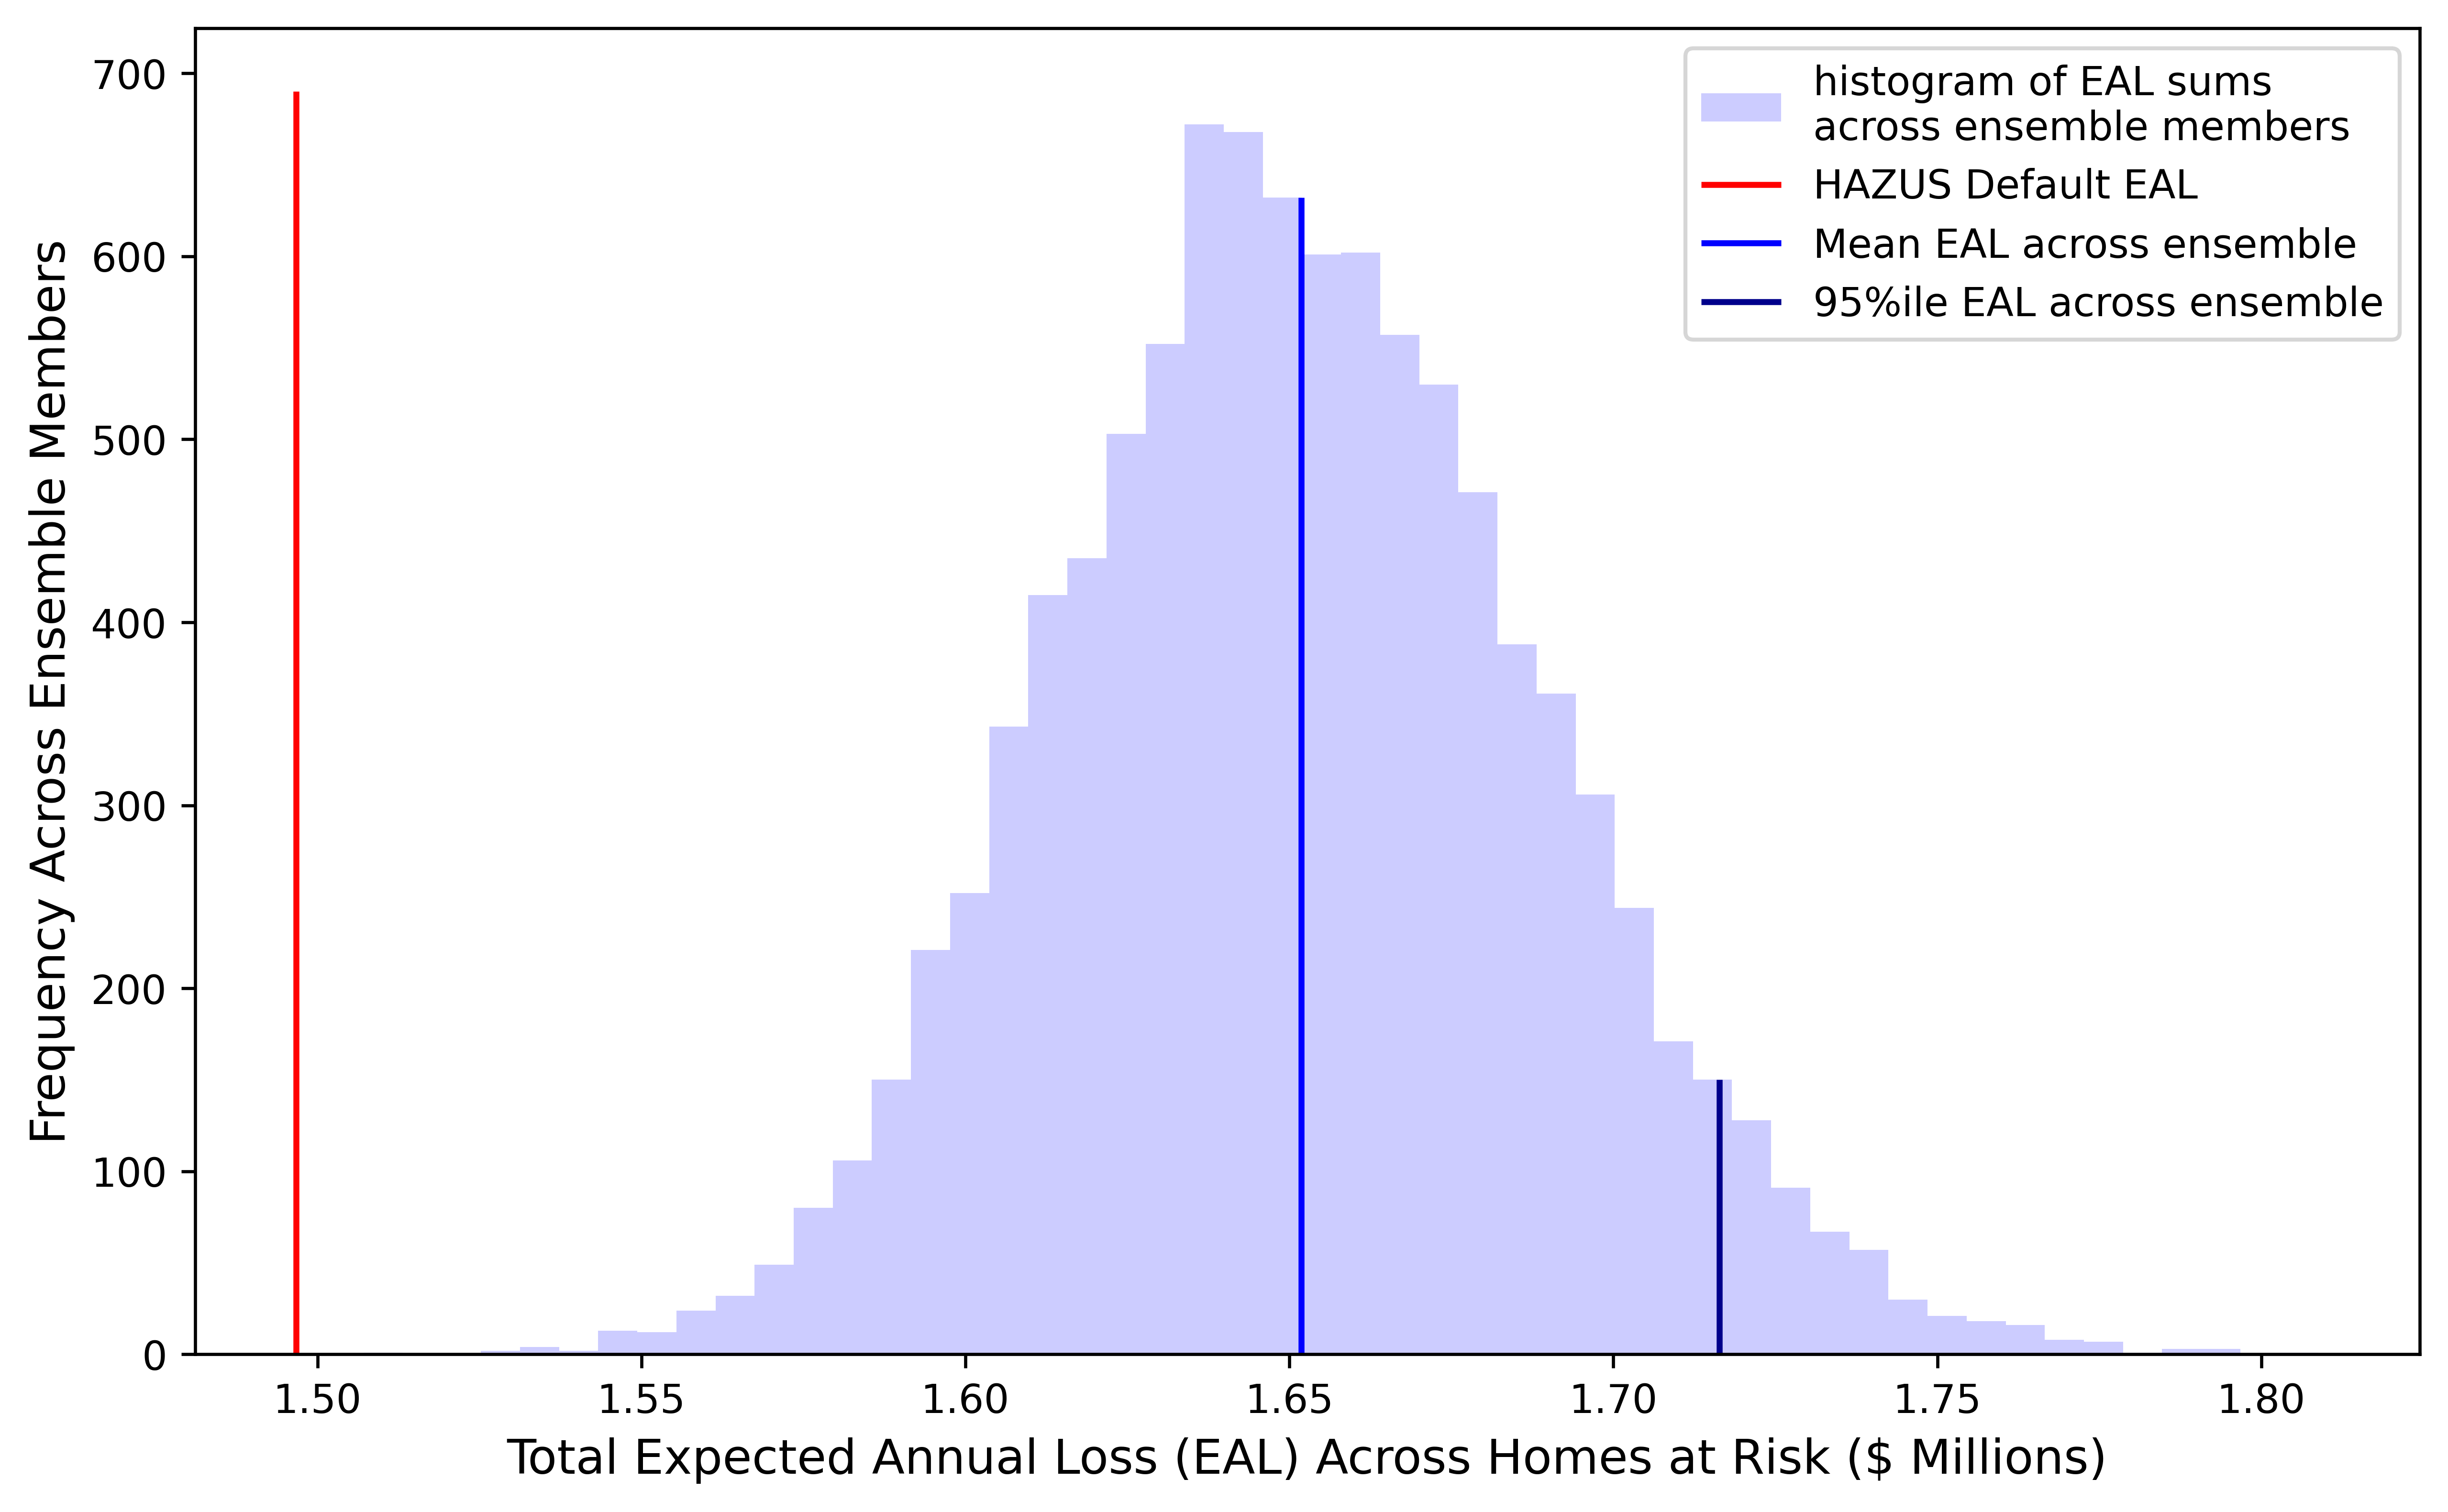

In [13]:
# Plot of the pdf of summed EAL within each SOW against the
# single value from default method
ens_sums = ens_df.groupby(['sow_ind'])['eal'].sum()/1e6
fig, ax = plt.subplots(figsize=(10, 6),
                       dpi=600)
ens_sums.plot(kind='hist', ax=ax, color='blue', bins=50, alpha=.2,
              label='histogram of EAL sums\nacross ensemble members')
ax.vlines(def_df['eal'].sum()/1e6, 0, 690, color='red', label='HAZUS Default EAL')
ax.vlines(ens_sums.mean(), 0, 632, color='blue', label='Mean EAL across ensemble')
ax.vlines(ens_sums.quantile(.95), 0, 150, color='darkblue', label='95%ile EAL across ensemble')
ax.set_xlabel('Total Expected Annual Loss (EAL) Across Homes at Risk ($ Millions)', size=12)
ax.set_ylabel('Frequency Across Ensemble Members', size=12)
ax.legend(loc='upper right')


# Save fig
fig.savefig('/jumbo/keller-lab/projects/icom/nsi_unc/figures/benchmark.png',
            bbox_inches='tight',
            dpi=600)

## Compare property level EAL

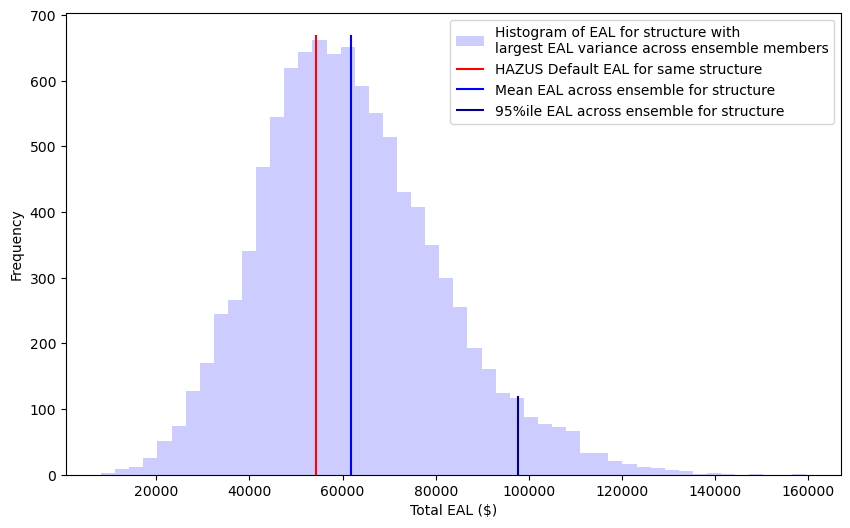

In [30]:
# Look at the proeprty with the largest variance in EAL across SOWs
# Plot the distribution of EAL for this property and plot
# what the benchmark point estimate is
max_var_id = ens_df.groupby(['fd_id'])['eal'].std().idxmax()
max_var_ens = ens_df[ens_df['fd_id'] == max_var_id]
max_var_def = def_df[def_df['fd_id'] == max_var_id]
fig, ax = plt.subplots(figsize=(10, 6))
max_var_ens['eal'].plot(kind='hist', ax=ax, color='blue', bins=50, alpha=.2,
                        label='Histogram of EAL for structure with\nlargest EAL variance across ensemble members')
ax.vlines(max_var_def['eal'], 0, 670, color='red', alpha=1, label='HAZUS Default EAL for same structure')
ax.vlines(max_var_ens['eal'].mean(), 0, 670, color='blue', label='Mean EAL across ensemble for structure')
ax.vlines(max_var_ens['eal'].quantile(.95), 0, 120, color='darkblue', label='95%ile EAL across ensemble for structure')
ax.set_xlabel('Total EAL ($)')
ax.legend(loc='upper right')

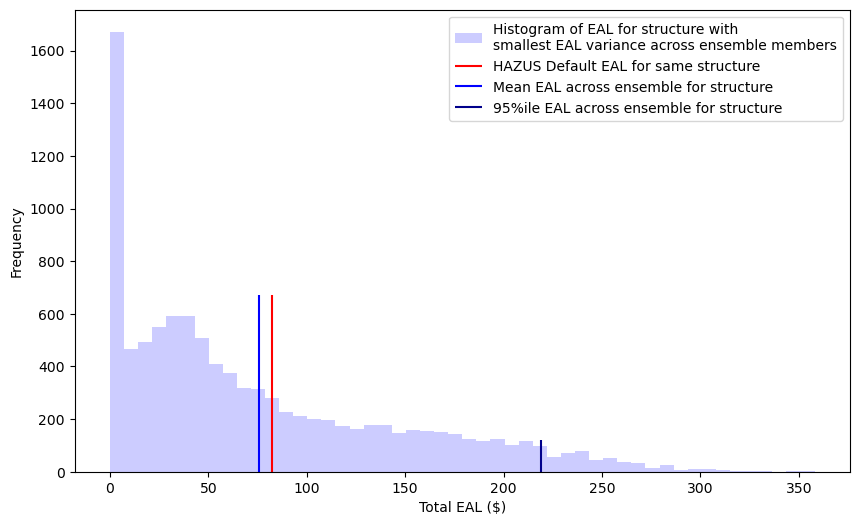

In [47]:
# Look at the proeprty with the smallest variance in EAL across SOWs
# Plot the distribution of EAL for this property and plot
# what the benchmark point estimate is
min_var_id = ens_df.groupby(['fd_id'])['eal'].std().idxmin()
min_var_ens = ens_df[ens_df['fd_id'] == min_var_id]
min_var_def = def_df[def_df['fd_id'] == min_var_id]
fig, ax = plt.subplots(figsize=(10, 6))
min_var_ens['eal'].plot(kind='hist', ax=ax, color='blue', bins=50, alpha=.2,
                        label='Histogram of EAL for structure with\nsmallest EAL variance across ensemble members')
ax.vlines(min_var_def['eal'], 0, 670, color='red', alpha=1, label='HAZUS Default EAL for same structure')
ax.vlines(min_var_ens['eal'].mean(), 0, 670, color='blue', label='Mean EAL across ensemble for structure')
ax.vlines(min_var_ens['eal'].quantile(.95), 0, 120, color='darkblue', label='95%ile EAL across ensemble for structure')
ax.set_xlabel('Total EAL ($)')
ax.legend(loc='upper right')

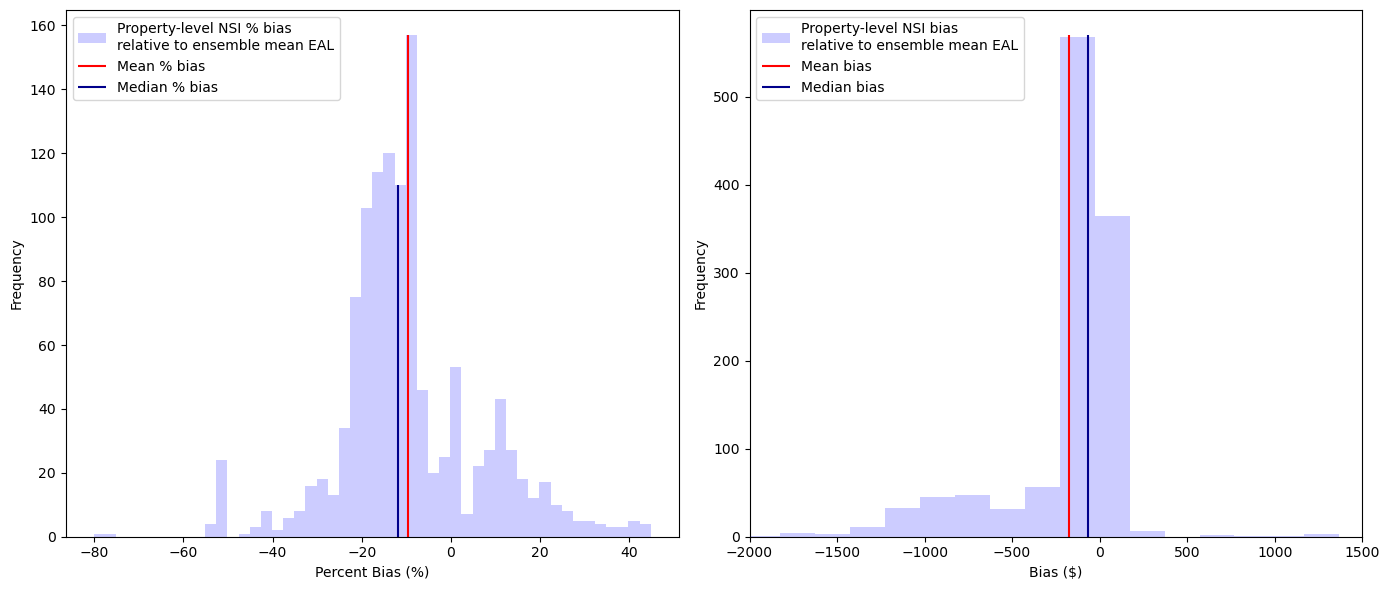

In [117]:
# Calculate the difference between mean EAL and default EAL
# Plot the distribution of these differences (the bias)
ens_means = ens_df.groupby(['fd_id'])['eal'].mean().reset_index()
mean_def_diff = pd.merge(ens_means,
                         def_df[['fd_id', 'eal']],
                         on='fd_id',
                         suffixes=['_ens', '_def'])
mean_def_diff['pct_bias'] = 100*(mean_def_diff['eal_def'] - mean_def_diff['eal_ens'])/mean_def_diff['eal_ens']
mean_def_diff['bias'] = (mean_def_diff['eal_def'] - mean_def_diff['eal_ens'])
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)
mean_def_diff['pct_bias'].plot(kind='hist', ax=ax[0], color='blue', bins=50, alpha=.2,
                           label='Property-level NSI % bias\nrelative to ensemble mean EAL')
ax[0].vlines(mean_def_diff['pct_bias'].mean(), 0, 157, color='red', alpha=1, label='Mean % bias')
ax[0].vlines(mean_def_diff['pct_bias'].median(), 0, 110, color='darkblue', alpha=1, label='Median % bias')
ax[0].set_xlabel('Percent Bias (%)')
ax[0].legend(loc='upper left')

mean_def_diff['bias'].plot(kind='hist', ax=ax[1], color='blue', bins=50, alpha=.2,
                           label='Property-level NSI bias\nrelative to ensemble mean EAL')
ax[1].vlines(mean_def_diff['bias'].mean(), 0, 570, color='red', alpha=1, label='Mean bias')
ax[1].vlines(mean_def_diff['bias'].median(), 0, 570, color='darkblue', alpha=1, label='Median bias')
ax[1].set_xlabel('Bias ($)')
ax[1].legend(loc='upper left')
ax[1].set_xlim([-2000, 1500])
fig.tight_layout()

# Compare inputs with and without uncertainty

In [22]:
# Compare ddfs w/o uncertainty to those with uncertainty
# Let's do 1SWB, the most common occtype in our case study
# according to the no uncertainty data
ddf_id = '1SWB'
hazus_id = '1SWB_A'
naccs_plot = naccs_ddfs[naccs_ddfs['ddf_id'] == ddf_id]
hazus_plot = hazus_ddfs[hazus_ddfs['ddf_id'] == hazus_id]
hazus_nounc_plot = hazus_nounc[hazus_nounc['ddf_id'] == hazus_id]

In [38]:
# Add low/high to hazus_plot
hazus_plot[['low', 'high']] = pd.DataFrame(hazus_plot['params'].tolist(),
                                           index=hazus_plot.index)

# Add low/mid/high to naccs_plot
naccs_plot[['low', 'mid', 'high']] = pd.DataFrame(naccs_plot['params'].tolist(),
                                                  index=naccs_plot.index)

/tmp/ipykernel_308437/440196230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hazus_plot[['low', 'high']] = pd.DataFrame(hazus_plot['params'].tolist(),
/tmp/ipykernel_308437/440196230.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naccs_plot[['low', 'mid', 'high']] = pd.DataFrame(naccs_plot['params'].tolist(),
/tmp/ipykernel_308437/440196230.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

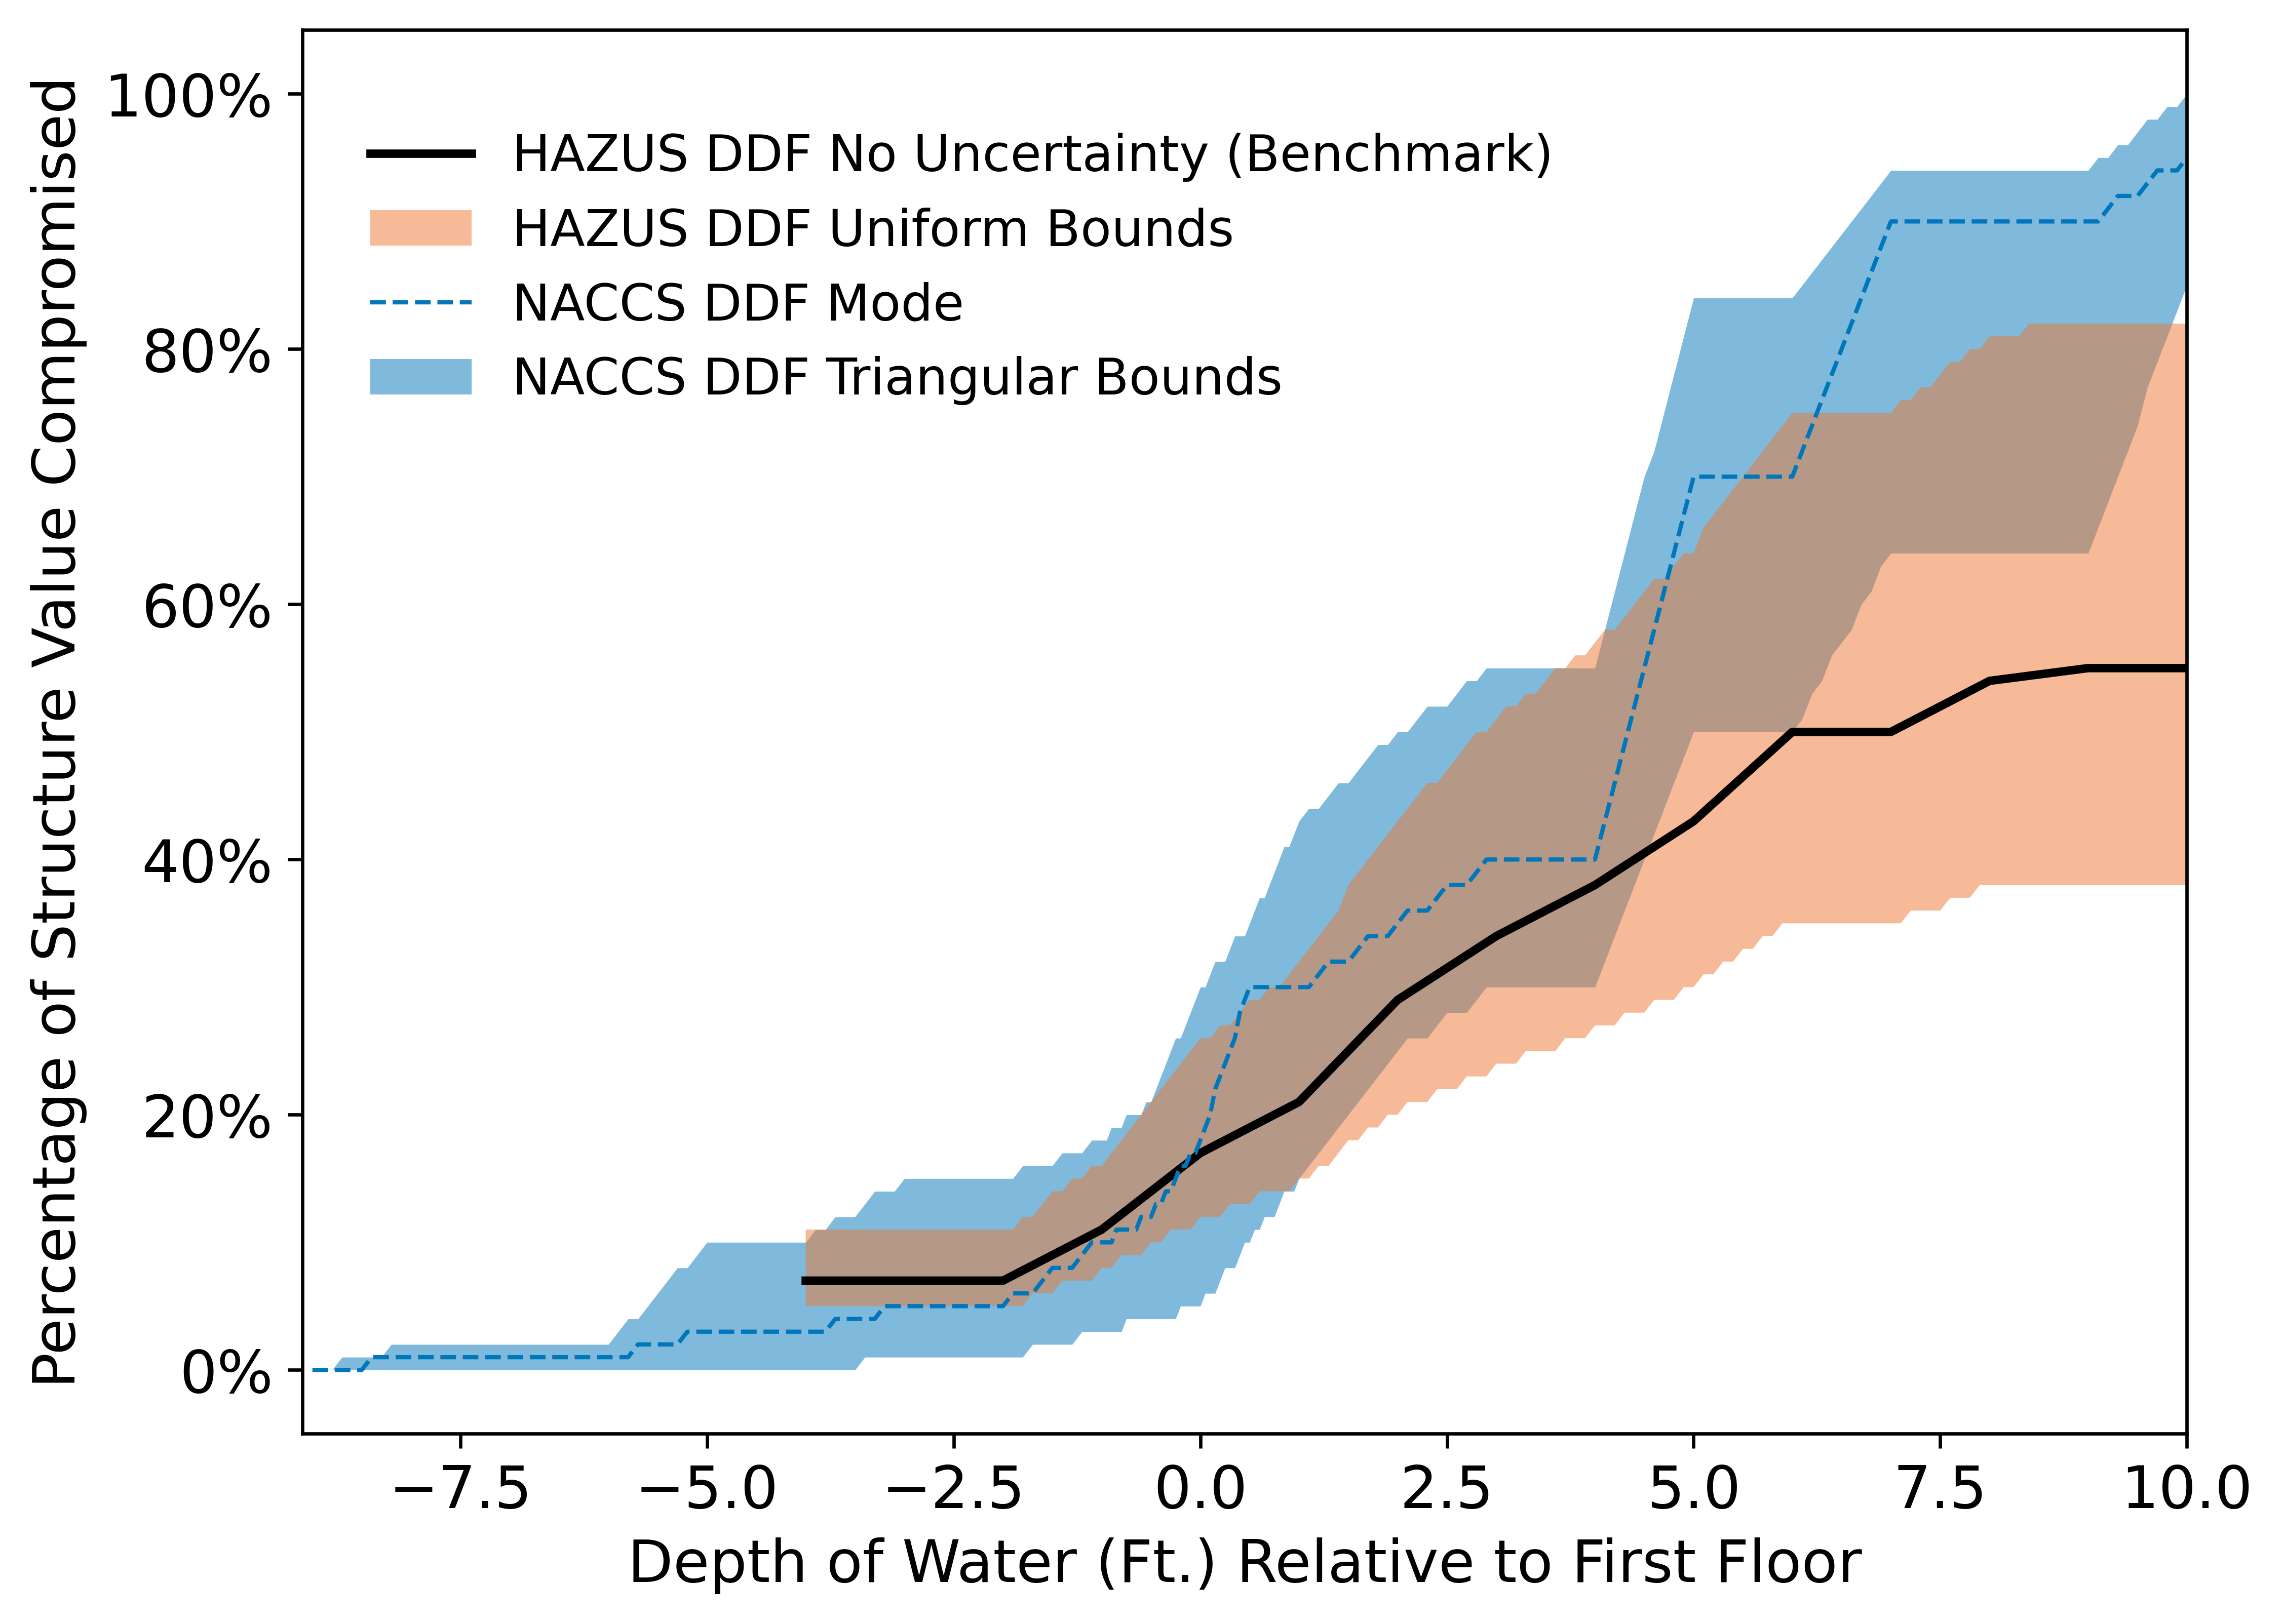

In [99]:
# Plot our One Story With Basement ddfs
fig, ax = plt.subplots(figsize=(8, 6),
                       dpi=600)

# First, plot no uncertainty as a black line
hazus_nounc_plot.plot(x='depth_ft',
                      y='rel_dam',
                      ax=ax,
                      lw=2,
                      legend=False,
                      color='black')

# Second, plot naccs mid as a dashed blue line
naccs_plot.plot(x='depth_ft',
                y='mid',
                ax=ax,
                lw=1,
                ls='dashed',
                legend=False,
                color='#0077BB')

# Third, plot naccs low/high as a solid area
ax.fill_between(naccs_plot['depth_ft'],
                naccs_plot['low'],
                naccs_plot['high'],
                alpha=.5,
                lw=0,
                color='#0077BB')

# Fourth, plot the hazus uncertainty low/high
ax.fill_between(hazus_plot['depth_ft'],
                hazus_plot['low'],
                hazus_plot['high'],
                alpha=.5,
                lw=0,
                color='#EE7733')

# Limit axis from -9.1 to +10.1
ax.set_xlim([-9.1, 10])

# Style the axes
ax.set_xlabel('Depth of Water (Ft.) Relative to First Floor', size=14)
ax.set_ylabel('Percentage of Structure Value Compromised', size=14)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.tick_params(labelsize=14)

# Add a custom legend in the top left
legend_elements = [Line2D([0], [0], color='black', lw=2, label='HAZUS DDF No Uncertainty (Benchmark)'),
                   Patch(facecolor='#EE7733', alpha=.5,
                         label='HAZUS DDF Uniform Bounds'),
                   Line2D([0], [0], color='#0077BB', lw=1, ls='dashed',
                          label='NACCS DDF Mode'),
                   Patch(facecolor='#0077BB', alpha=.5,
                         label='NACCS DDF Triangular Bounds'),
                   ]
ax.legend(handles=legend_elements,
          bbox_to_anchor=(.35, .83),
          loc='center',
          fontsize='large',
          frameon=False)

fig.savefig('/jumbo/keller-lab/projects/icom/nsi_unc/figures/ddf_ex.png',
            bbox_inches='tight',
            dpi=600)

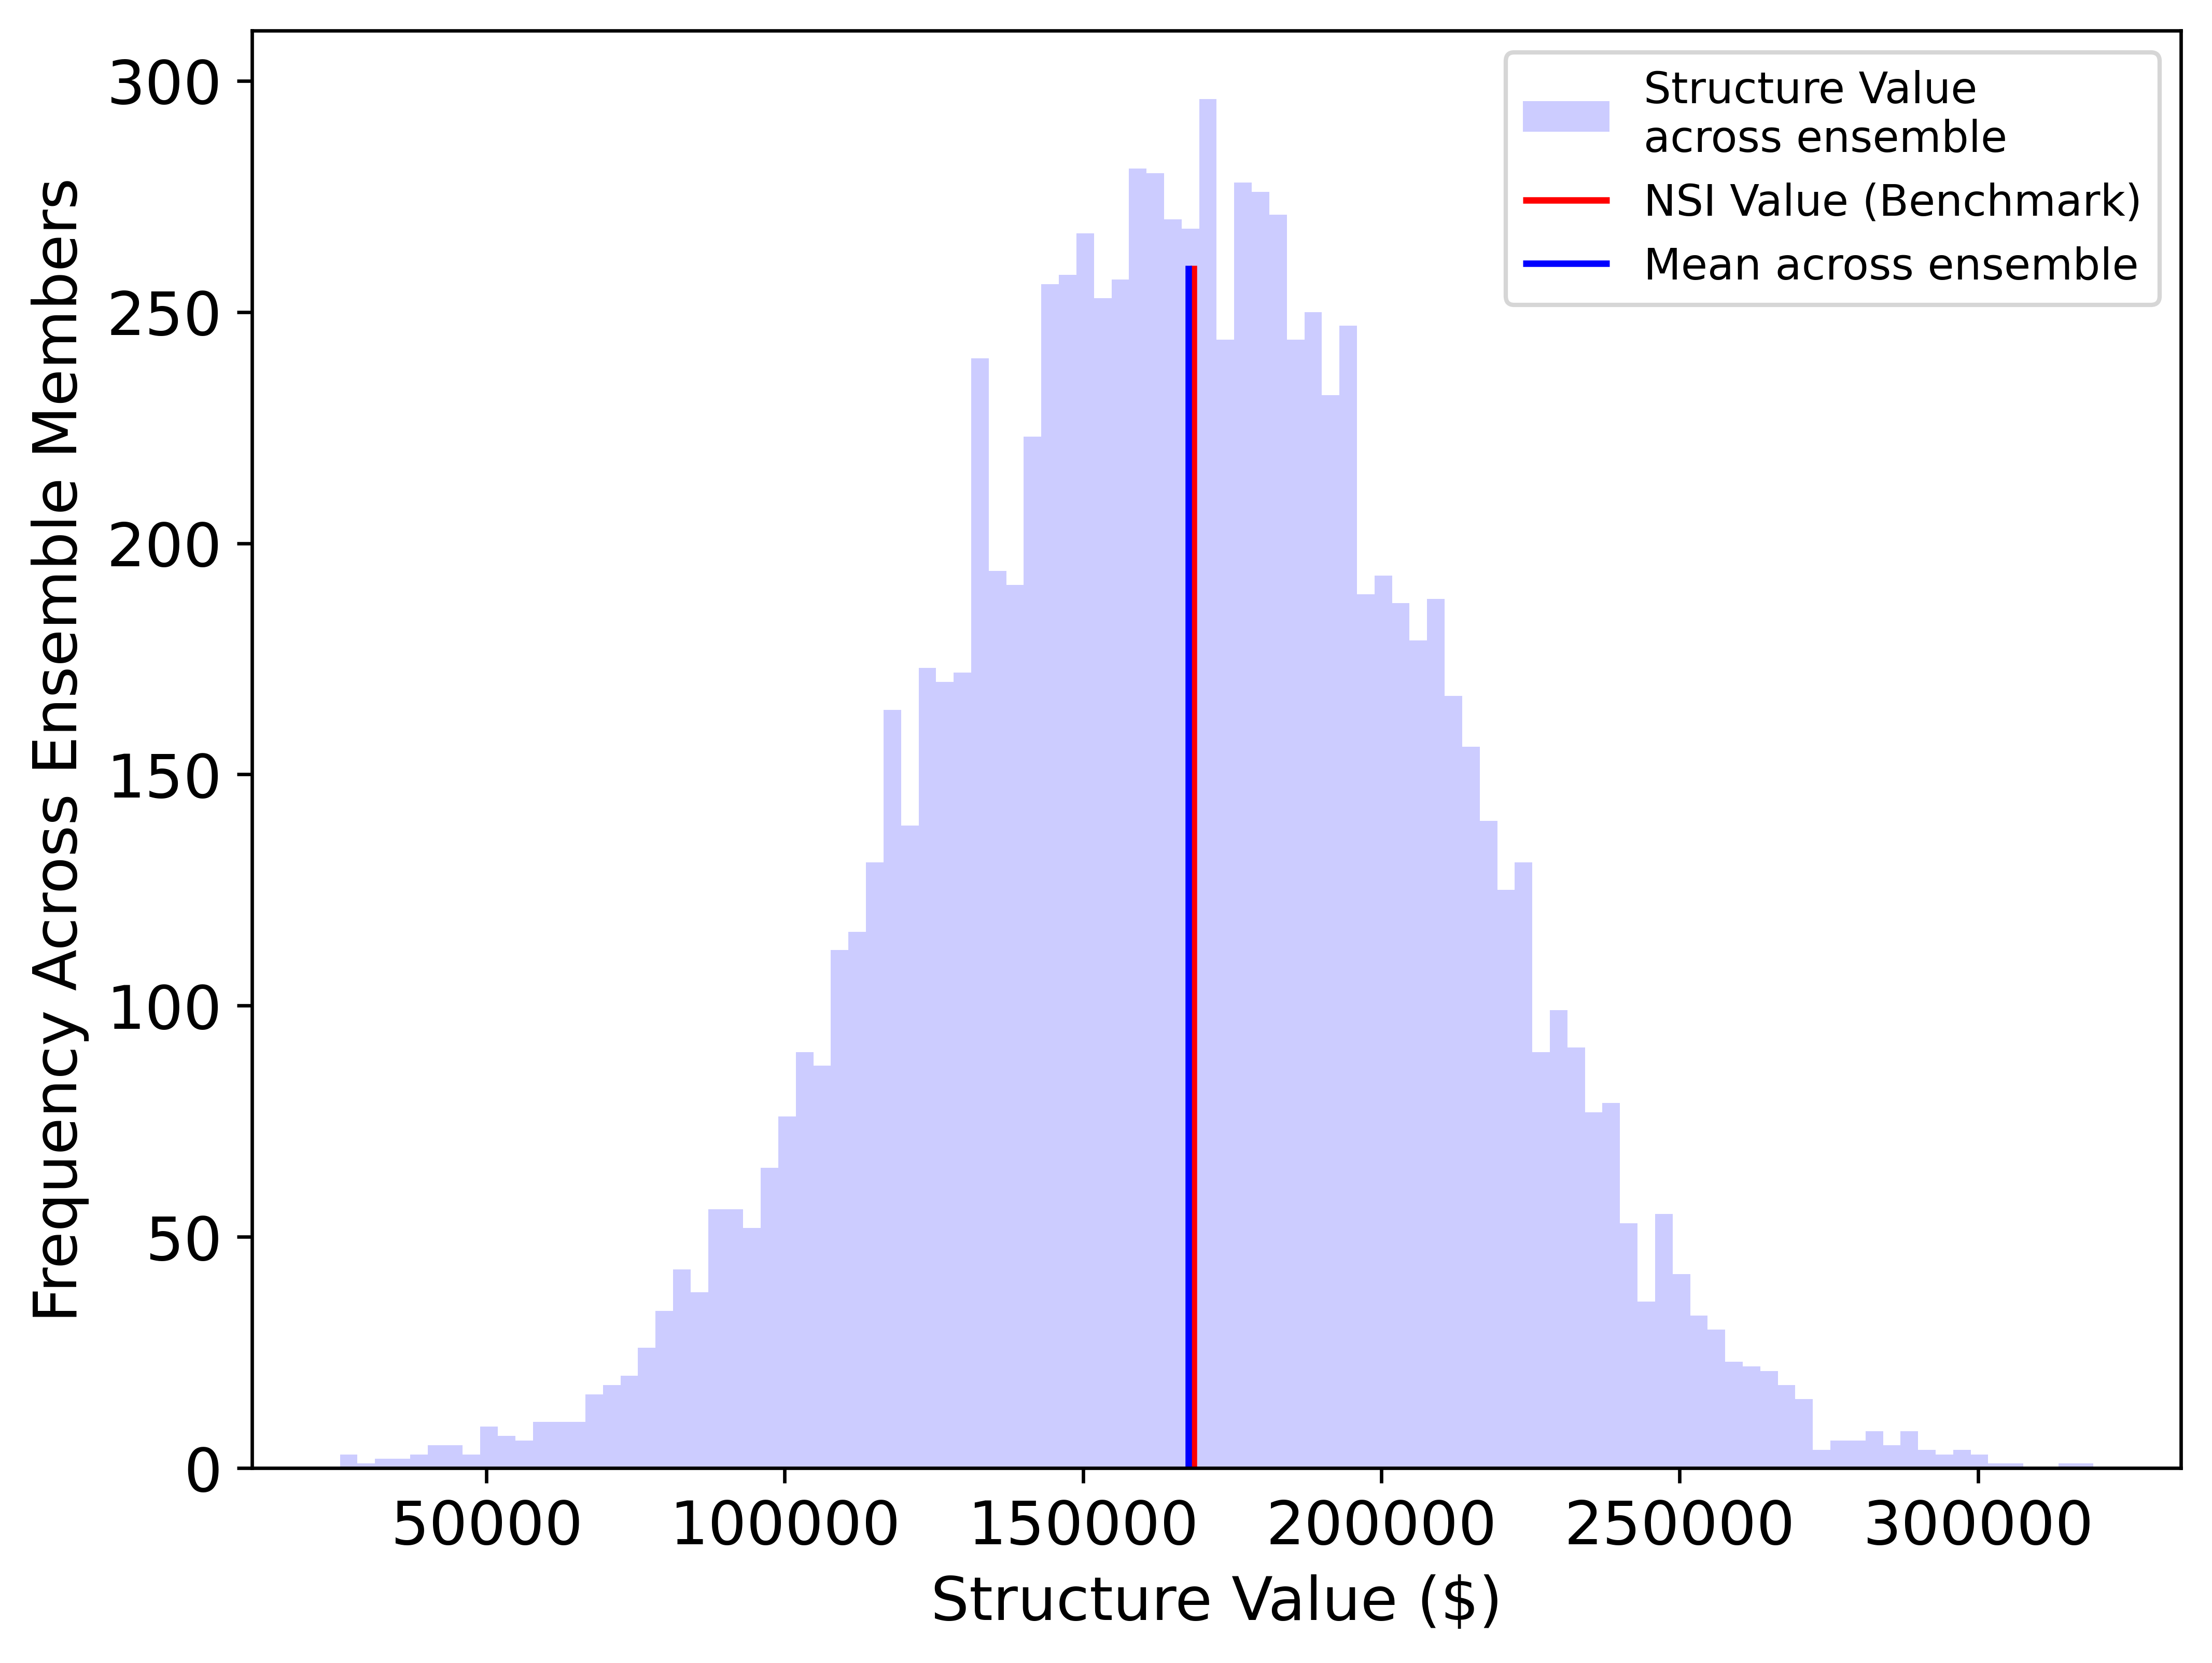

In [102]:
# Get a figure for uncertainty in structure value
fd_id = 570878975
# The fdid above has structure value of 168546 w/o unc
# The median w/i unc is 158055, so close enough
ens_struct = ens_df[ens_df['fd_id'] == fd_id]

# Plot of the pdf of val for the example structure vs.
# single value from default method
fig, ax = plt.subplots(figsize=(8, 6),
                       dpi=600)
ens_struct['val_s'].plot(kind='hist', ax=ax, color='blue', bins=100, alpha=.2,
                         label='Structure Value\nacross ensemble')
ax.vlines(168546, 0, 260, color='red', label='NSI Value (Benchmark)')
ax.vlines(ens_struct['val_s'].mean(), 0, 260, color='blue', label='Mean across ensemble')
ax.set_xlabel('Structure Value ($)', size=14)
ax.set_ylabel('Frequency Across Ensemble Members', size=14)
ax.tick_params(labelsize=14)
ax.legend(loc='upper right')


# Save fig
fig.savefig('/jumbo/keller-lab/projects/icom/nsi_unc/figures/val_unc.png',
            bbox_inches='tight',
            dpi=600)

In [89]:
def_df['val_struct'].describe()

count    7.310000e+02
mean     1.743740e+05
std      1.427268e+05
min      9.269533e+04
25%      1.293368e+05
50%      1.580555e+05
75%      1.918105e+05
max      3.745470e+06
Name: val_struct, dtype: float64